In [72]:
####This step was used in-order to use google colab. Google drive was used to  
####store the dataset in a folder named jpg. An additional folder 17Flowers was
####created to load training and valdation data from jpg

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#This section was done in order to preprocess the data and divide it 
#into training and validation folders

#Importing libraries
import os
import glob
import numpy as np
from shutil import copy2

# setting the input and output path
input_path  = "/content/drive/My Drive/17Flowers/jpg"
output_path = "/content/drive/My Drive/17Flowers/Dataset/train"
validation_path = "/content/drive/My Drive/17Flowers/Dataset/test"

#Reading the paths to all images in the jpg folder
files = glob.glob(input_path + "/*.jpg")
files.sort()

# Initialising variables to keep track of
label = 0
i = 0
m = 0
j = 80
k = 0
# Creating a list with class names in the same order they are present in data

class_names = ["daffodil", "snowdrop", "lilyvalley", "bluebell", "crocus",
			   "iris", "tigerlily", "tulip", "fritillary", "sunflower", 
			   "daisy", "coltsfoot", "dandelion", "cowslip", "buttercup",
			   "windflower", "pansy"]

#Creating lists that will contain paths to different classes 
label_path = []
label_v = []
for name in class_names:
  x = output_path + '/' + name
  label_path.append(x)
  y = validation_path + '/' + name
  label_v.append(y)

# looping over the class labels
for x in range(len(class_names)):
  #Creating directories for training and validation data
  for labels in class_names :
    os.chdir(output_path)
    os.system("mkdir " + class_names[label])
    os.chdir(validation_path)
    os.system("mkdir " + class_names[label])
  
  for image in files[m:j]:
    #Dividing the data into 80:20 for training and validation
    if (k <= 63):
      os.chdir(output_path)
      copy2(image, label_path[i])
    else:
      os.chdir(validation_path)
      copy2(image, label_v[i])
    k+=1  
  
  label += 1
  i +=  1
  m += 80
  j += 80
  k = 0

In [0]:
#Importing all required libraries 
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from tensorflow.python.data import Dataset
from tensorflow import keras
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.utils import to_categorical
import keras
from keras.utils import to_categorical
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from random import shuffle

In [0]:
#Loading the pretrained VGG16 model

from keras.applications import VGG16
 
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

#Extracting the features and setting the directories
train_dir = '/content/drive/My Drive/17Flowers/Dataset/train'
validation_dir = '/content/drive/My Drive/17Flowers/Dataset/test'
 
#Setting the values of splits
nTrain = 1088
nVal = 272


In [84]:
# Freeze the layers except the last 4 layers. 
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)
    

<keras.engine.topology.InputLayer object at 0x7fe6035b4940> False
<keras.layers.convolutional.Conv2D object at 0x7fe6035b4e10> False
<keras.layers.convolutional.Conv2D object at 0x7fe6035b4278> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe6035b4d30> False
<keras.layers.convolutional.Conv2D object at 0x7fe6034942b0> False
<keras.layers.convolutional.Conv2D object at 0x7fe603451710> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe603451cf8> False
<keras.layers.convolutional.Conv2D object at 0x7fe6038e4ef0> False
<keras.layers.convolutional.Conv2D object at 0x7fe6038c2f28> False
<keras.layers.convolutional.Conv2D object at 0x7fe6033fa240> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe690bded30> False
<keras.layers.convolutional.Conv2D object at 0x7fe60828da90> False
<keras.layers.convolutional.Conv2D object at 0x7fe6082efd30> False
<keras.layers.convolutional.Conv2D object at 0x7fe605388668> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe6053790b8> Fa

As it can be seen above 18 layers were present for the VGG16 model. Out of these , the first 14 layers were frozen
and only the last 3 convolutional layers and the pooling layer was used for learning transfer 

In [85]:
from keras import models
from keras import layers
from keras import optimizers
 
# Creation of the main model
model = models.Sequential()
 
# Add the above vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers. A fully connected layer is added after the VGG and a softmax
#layer with 17 outputs for 17 classes
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_14 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_24 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 17)                17425     
Total para

In [86]:
#The data generators are then setup with some data augmentation

image_size = 224
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Setting batch sizes
train_batchsize = 20
val_batchsize = 2
 
#Two separate generators for validation and training
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical',
        shuffle = shuffle)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_size, image_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [89]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.00001),
              metrics=['acc'])
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=35,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/35
55/54 [==============================] - 34s 612ms/step - loss: 1.0073 - acc: 0.6868 - val_loss: 1.0869 - val_acc: 0.6618
Epoch 2/35
55/54 [==============================] - 28s 514ms/step - loss: 0.8442 - acc: 0.7477 - val_loss: 0.9696 - val_acc: 0.7096
Epoch 3/35
55/54 [==============================] - 28s 516ms/step - loss: 0.8126 - acc: 0.7473 - val_loss: 0.9443 - val_acc: 0.7169
Epoch 4/35
55/54 [==============================] - 29s 521ms/step - loss: 0.7003 - acc: 0.7773 - val_loss: 0.8947 - val_acc: 0.7132
Epoch 5/35
55/54 [==============================] - 28s 511ms/step - loss: 0.6242 - acc: 0.7918 - val_loss: 0.8810 - val_acc: 0.7206
Epoch 6/35
55/54 [==============================] - 28s 513ms/step - loss: 0.5958 - acc: 0.8264 - val_loss: 0.8046 - val_acc: 0.7316
Epoch 7/35
55/54 [==============================] - 28s 516ms/step - loss: 0.5322 - acc: 0.8272 - val_loss: 0.8883 - val_acc: 0.7390
Epoch 8/35
55/54 [==============================] - 28s 513ms/step - 

Two types of activation functions were used, Adam and RMSProp. Both yielded similar results.  Adam however  yielded an accuracy closer to 91% for one special epoch

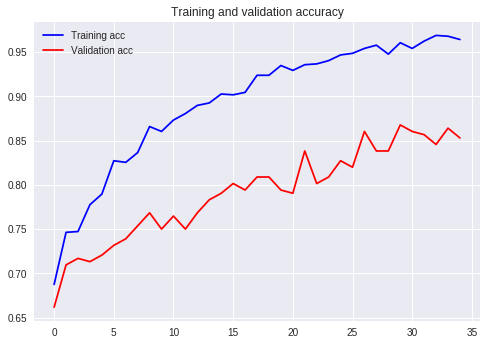

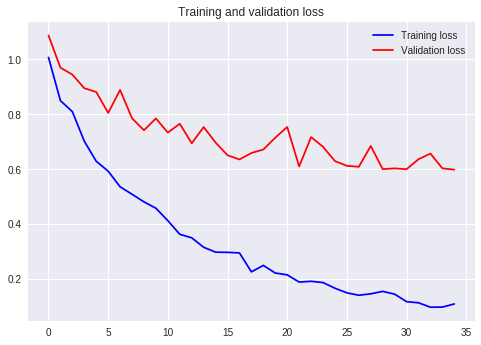

In [96]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [0]:
from keras import backend as K
import tensorflow as tf

top_values, top_indices = K.get_session().run(tf.nn.top_k(val_acc, k=5))

In [95]:
print (top_values) #These are the top 5 accuracies obtained

[0.86764705 0.8639706  0.8639706  0.8639706  0.8602941 ]


In [0]:
#The topmost accuracy obtained was 86.76%